# Importing required libraries

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

## Polygon to get market data

In [2]:
%pip install polygon-api-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [2]:
from polygon import RESTClient

### Get API key and import it
when running on local machine, put api key in .env and import using load_dotenv
```
from dotenv import load_dotenv
import os

load_dotenv()
my_token = os.getenv("TOKEN_ID")
```

In [3]:
from google.colab import userdata
token_id = userdata.get("TokenID")
client = RESTClient(token_id)

In [4]:
client

In [5]:
stockTicker = 'AAPL' #apple stocks

In [8]:
data_values = client.get_aggs(stockTicker, 1, 'day', from_ = '2023-05-10', to='2024-02-20')

In [9]:
data_values[0]

Agg(open=173.02, high=174.03, low=171.9, close=173.555, volume=53724501.0, vwap=173.1737, timestamp=1683691200000, transactions=511486, otc=None)

In [10]:
dir(data_values[0])

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'close',
 'from_dict',
 'high',
 'low',
 'open',
 'otc',
 'timestamp',
 'transactions',
 'volume',
 'vwap']

# Create Dataset

In [39]:
dataset = pd.DataFrame(data_values)

In [40]:
dataset.head()

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,173.02,174.0300,171.9000,173.555,53724501.0,173.1737,1683691200000,511486,None
1,173.85,174.5900,172.1700,173.750,49473076.0,173.4903,1683777600000,501955,None
2,173.62,174.0600,171.0000,172.570,45533138.0,172.3696,1683864000000,490533,None
3,173.16,173.2100,171.4700,172.070,37264259.0,172.1109,1684123200000,444785,None
4,171.99,173.1383,171.7991,172.070,42110293.0,172.2781,1684209600000,436165,None


## Need to convert the timestamp to date and use it as index

In [22]:
dir(dataset)

['Date',
 'T',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__dataframe__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__re

In [41]:
dataset['Date'] = dataset['timestamp'].apply(lambda x: pd.to_datetime(x*1000000))

In [42]:
dataset = dataset[['Date', 'close']]

In [43]:
dataset

,Date,close
0,2023-05-10 04:00:00,173.555
1,2023-05-11 04:00:00,173.750
2,2023-05-12 04:00:00,172.570
3,2023-05-15 04:00:00,172.070
4,2023-05-16 04:00:00,172.070
...,...,...
191,2024-02-13 05:00:00,185.040
192,2024-02-14 05:00:00,184.150
193,2024-02-15 05:00:00,183.860
194,2024-02-16 05:00:00,182.310


In [44]:
dataset.head()

,Date,close
0,2023-05-10 04:00:00,173.555
1,2023-05-11 04:00:00,173.750
2,2023-05-12 04:00:00,172.570
3,2023-05-15 04:00:00,172.070
4,2023-05-16 04:00:00,172.070


# Setup Function for dataset generation

In [47]:
def create_dataset(stock_ticker, time, multiplier, from_, to_):
  dataset = pd.DataFrame(client.get_aggs(stockTicker, multiplier, time, from_ = from_, to=to_))
  dataset['Date'] = dataset['timestamp'].apply(lambda x: pd.to_datetime(x*1000000))
  return dataset[['Date', 'close']]

In [51]:
try_dataset = create_dataset("AAPL", "day",1, '2000-01-01', '2100-01-01')
try_dataset

,Date,close
0,2022-04-19 04:00:00,167.40
1,2022-04-20 04:00:00,167.23
2,2022-04-21 04:00:00,166.42
3,2022-04-22 04:00:00,161.79
4,2022-04-25 04:00:00,162.88
...,...,...
497,2024-04-11 04:00:00,175.04
498,2024-04-12 04:00:00,176.55
499,2024-04-15 04:00:00,172.69
500,2024-04-16 04:00:00,169.38


# Setup Pytorch

In [45]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [46]:
device

'cpu'

In [52]:
appl_dataset = try_dataset

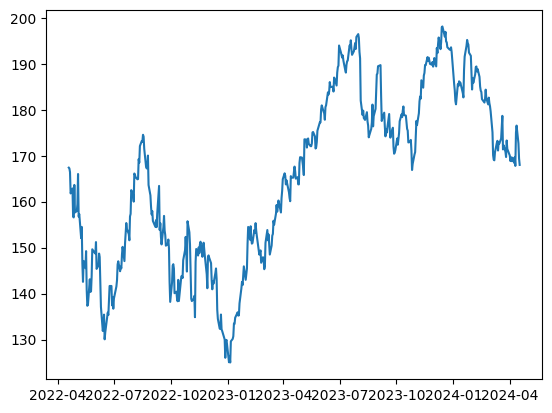

In [55]:
appl_dataset["Date"] = pd.to_datetime(appl_dataset["Date"])
plt.plot(appl_dataset["Date"], appl_dataset["close"])

In [56]:
nvidia_stock = create_dataset("NVDA", "day",1, '2000-01-01', '2100-01-01')
nvidia_stock

,Date,close
0,2022-04-19 04:00:00,167.40
1,2022-04-20 04:00:00,167.23
2,2022-04-21 04:00:00,166.42
3,2022-04-22 04:00:00,161.79
4,2022-04-25 04:00:00,162.88
...,...,...
497,2024-04-11 04:00:00,175.04
498,2024-04-12 04:00:00,176.55
499,2024-04-15 04:00:00,172.69
500,2024-04-16 04:00:00,169.38


In [57]:
def plot_closing_values(data):
  data["Date"] = pd.to_datetime(data["Date"])
  plt.plot(data["Date"], data["close"])

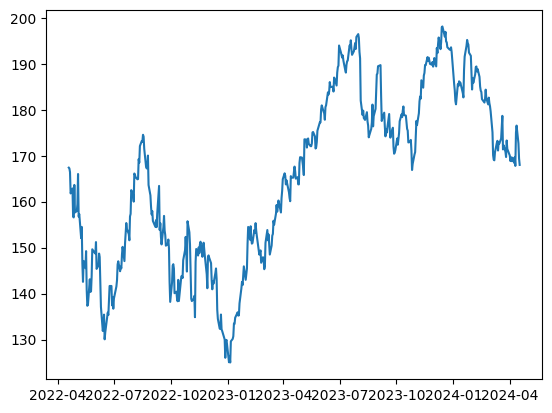

In [58]:
plot_closing_values(nvidia_stock)

In [61]:
from copy import deepcopy

def data_preprocessing(data, steps):
  data = deepcopy(data)
  data.set_index('Date', inplace = True)

  for i in range(1, steps+1):
    data[f"close(n-{i})"] = data['close'].shift(i)

  data.dropna(inplace = True)
  return data

In [62]:
# for weekly data, steps = 7
nvidia_weekly = data_preprocessing(nvidia_stock, 7)
nvidia_weekly

,close,close(n-1),close(n-2),close(n-3),close(n-4),close(n-5),close(n-6),close(n-7)
Date,,,,,,,,
2022-04-28 04:00:00,163.64,156.57,156.80,162.88,161.79,166.42,167.23,167.40
2022-04-29 04:00:00,157.65,163.64,156.57,156.80,162.88,161.79,166.42,167.23
2022-05-02 04:00:00,157.96,157.65,163.64,156.57,156.80,162.88,161.79,166.42
2022-05-03 04:00:00,159.48,157.96,157.65,163.64,156.57,156.80,162.88,161.79
2022-05-04 04:00:00,166.02,159.48,157.96,157.65,163.64,156.57,156.80,162.88
...,...,...,...,...,...,...,...,...
2024-04-11 04:00:00,175.04,167.78,169.67,168.45,169.58,168.82,169.65,168.84
2024-04-12 04:00:00,176.55,175.04,167.78,169.67,168.45,169.58,168.82,169.65
2024-04-15 04:00:00,172.69,176.55,175.04,167.78,169.67,168.45,169.58,168.82


In [112]:
np_dataset = nvidia_weekly.to_numpy()
np_dataset

array([[163.64, 156.57, 156.8 , ..., 166.42, 167.23, 167.4 ],
       [157.65, 163.64, 156.57, ..., 161.79, 166.42, 167.23],
       [157.96, 157.65, 163.64, ..., 162.88, 161.79, 166.42],
       ...,
       [172.69, 176.55, 175.04, ..., 168.45, 169.58, 168.82],
       [169.38, 172.69, 176.55, ..., 169.67, 168.45, 169.58],
       [168.  , 169.38, 172.69, ..., 167.78, 169.67, 168.45]])

In [113]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
np_dataset = scaler.fit_transform(np_dataset)

np_dataset

array([[ 0.05677931, -0.1366808 , -0.13038719, ...,  0.13284991,
         0.15501437,  0.15966617],
       [-0.1071282 ,  0.05677931, -0.1366808 , ...,  0.00615679,
         0.13284991,  0.15501437],
       [-0.09864551, -0.1071282 ,  0.05677931, ...,  0.03598303,
         0.00615679,  0.13284991],
       ...,
       [ 0.30441921,  0.41004241,  0.36872349, ...,  0.18839787,
         0.21931865,  0.19852237],
       [ 0.21384594,  0.30441921,  0.41004241, ...,  0.22178137,
         0.18839787,  0.21931865],
       [ 0.17608428,  0.21384594,  0.30441921, ...,  0.1700643 ,
         0.22178137,  0.18839787]])

In [114]:
# todays price would be the output of the output(Y) of all the 7 days before it
# need to flip the data so that the day decrease from the output in descending order

X = np_dataset[:,  1:]
X = deepcopy(np.flip(X, axis = 1))
Y = np_dataset[:, 0]

X.shape, Y.shape

((495, 7), (495,))

In [115]:
split_index = int(len(X) * 0.85)
split_index

420

In [116]:
x_train = X[:split_index]
x_test = X[split_index:]

y_train = Y[:split_index]
y_test = Y[split_index:]

In [117]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((420, 7), (420,), (75, 7), (75,))

In [118]:
#reshaping for LSTM, added dimension in the end

x_train = x_train.reshape((-1, 7, 1))
x_test = x_test.reshape((-1, 7, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))


In [119]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((420, 7, 1), (420, 1), (75, 7, 1), (75, 1))

In [120]:
#changing to tensors
x_train = torch.tensor(x_train).float()
x_test = torch.tensor(x_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()


In [121]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([420, 7, 1]),
 torch.Size([420, 1]),
 torch.Size([75, 7, 1]),
 torch.Size([75, 1]))

In [122]:
from torch.utils.data import Dataset

class LSTMDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, i):
    return self.x[i], self.y[i]

train_dataset = LSTMDataset(x_train, y_train)
test_dataset = LSTMDataset(x_test, y_test)

In [123]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle = False)

In [124]:
train_loader

In [125]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([16, 7, 1]) torch.Size([16, 1])


# LSTM Class

In [126]:
class LSTM(nn.Module):
  def __init__(self, input, hidden_size, num_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(1, 4, 1)
model.to(device)
model


LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [127]:
def train():
  model.train(True)
  print(f'Epoch : {epoch +1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss +=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index %10 ==9:
      avg_loss = running_loss /10
      print(f'Batch {batch_index + 1}, Loss: {avg_loss}')
      running_loss = 0.0

  print()

In [128]:
def evaluate():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss = running_loss/len(test_loader)
  print(f"Evaluation : {avg_loss}")
  print("-"*50)
  print()



In [135]:
num_epochs = 20
loss_function = nn.MSELoss()
learning_rate = 0.002
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
  train()
  evaluate()

Epoch : 1
Batch 10, Loss: 0.016109990328550337
Batch 20, Loss: 0.013858513440936804

Evaluation : 0.012400082778185606
--------------------------------------------------

Epoch : 2
Batch 10, Loss: 0.014273305656388402
Batch 20, Loss: 0.01388000650331378

Evaluation : 0.012371218856424093
--------------------------------------------------

Epoch : 3
Batch 10, Loss: 0.01244617523625493
Batch 20, Loss: 0.0123585085850209

Evaluation : 0.011130016483366489
--------------------------------------------------

Epoch : 4
Batch 10, Loss: 0.011546239769086242
Batch 20, Loss: 0.013985712546855211

Evaluation : 0.013465793430805206
--------------------------------------------------

Epoch : 5
Batch 10, Loss: 0.011546101467683912
Batch 20, Loss: 0.01301716179586947

Evaluation : 0.009181724488735199
--------------------------------------------------

Epoch : 6
Batch 10, Loss: 0.01271968763321638
Batch 20, Loss: 0.01212167227640748

Evaluation : 0.014104211330413818
---------------------------------

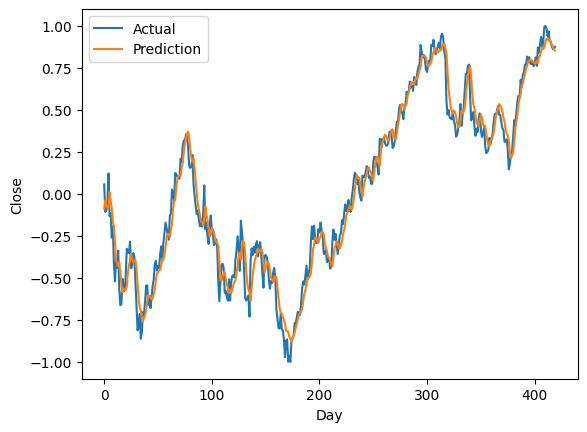

In [136]:
with torch.no_grad():
  predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label = "Actual")
plt.plot(predicted, label = "Prediction")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [143]:
#scaling the values back
def inverse_transformation(predicted, target_shape_array):
  train_predictions = predicted.flatten()
  dum = np.zeros((target_shape_array.shape[0], 8)) # length of the whole input matrix so close + ..... + close(n-7)
  dum[:, 0] = train_predictions
  dum = scaler.inverse_transform(dum)
  train_predictions = deepcopy(dum[:, 0])
  return train_predictions

In [138]:
train_predictions = inverse_transformation(predicted, x_train)

In [139]:
new_y_train = inverse_transformation(y_train, x_train)

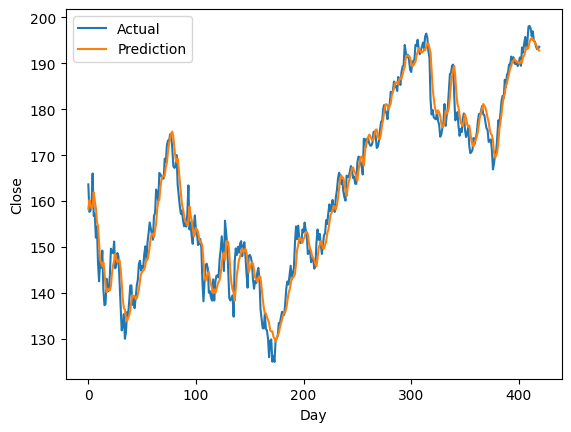

In [140]:
plt.plot(new_y_train, label = "Actual")
plt.plot(train_predictions, label = "Prediction")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

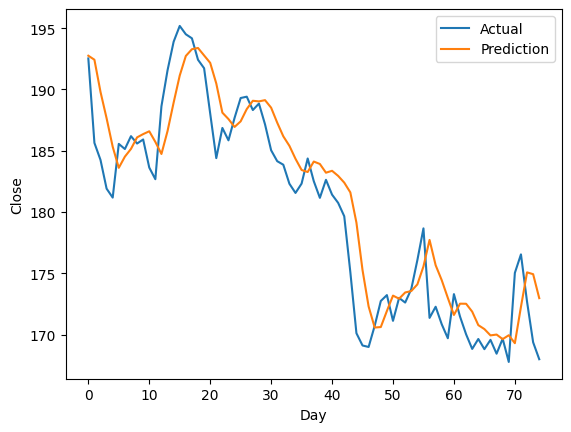

In [144]:
with torch.no_grad():
  predicted = model(x_test.to(device)).to('cpu').numpy()
test_predictions = inverse_transformation(predicted, x_test)
new_y_test = inverse_transformation(y_test, x_test)

plt.plot(new_y_test, label = "Actual")
plt.plot(test_predictions, label = "Prediction")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()